<a href="https://colab.research.google.com/github/james-tiger/Mel-Frequency-Cepstral-Coefficients-MFCCs-Long-Short-Term-Memory-LSTM-/blob/main/Final_Work_Porject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Analyzing Disordered Audio Speech - MFCC + LSTM (FIXED VERSION)
# Author: Mohamed Ashraf
# Adapted for Russian Voice Dataset
# Project Speech Voice Disorder Detection

# =============================================================================
# 1. ENVIRONMENT SETUP AND INSTALLATIONS
# =============================================================================

# Install required libraries
!pip install librosa
!pip install tensorflow
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install numpy
!pip install gradio
!pip install soundfile
!pip install kagglehub

# Import necessary libraries
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import warnings
import pickle
import json
warnings.filterwarnings('ignore')

print("All libraries installed successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Librosa version: {librosa.__version__}")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


All libraries installed successfully!
TensorFlow version: 2.18.0
Librosa version: 0.11.0


In [ ]:

# =============================================================================
# 2. DATASET LOADING FROM KAGGLE
# =============================================================================

# Configuration
SAMPLE_RATE = 22050  # Standard sample rate for audio processing
N_MFCC = 13  # Number of MFCC coefficients
MAX_PAD_LEN = 174  # Maximum padding length for sequences

print("Loading Russian Voice Dataset from Kaggle...")

# Download the dataset using kagglehub
import kagglehub
dataset_path = kagglehub.dataset_download("mhantor/russian-voice-dataset")
print(f"Dataset downloaded to: {dataset_path}")

# Explore the downloaded dataset structure
print("\nExploring dataset structure:")
audio_file_count = 0
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    audio_files = [f for f in files if f.lower().endswith(('.wav', '.mp3', '.flac', '.m4a', '.ogg'))]
    for file in audio_files[:5]:  # Show first 5 audio files
        print(f"{subindent}{file}")
        audio_file_count += 1
    if len(audio_files) > 5:
        print(f"{subindent}... and {len(audio_files) - 5} more audio files")
        audio_file_count += len(audio_files) - 5

print(f"\nTotal audio files found: {audio_file_count}")


Loading Russian Voice Dataset from Kaggle...


100%|██████████| 1.30G/1.30G [00:12<00:00, 116MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/mhantor/russian-voice-dataset/versions/3

Exploring dataset structure:
3/
  Disorder Voices/
    Disorder Voices/
      327.wav
      1320.wav
      78.wav
      1240.wav
      724.wav
      ... and 1995 more audio files
  Normal Voices/
    Normal Voices/
      327.wav
      1320.wav
      78.wav
      1240.wav
      724.wav
      ... and 1995 more audio files

Total audio files found: 4000


In [ ]:

# =============================================================================
# 3. DATA PREPROCESSING AND FEATURE EXTRACTION
# =============================================================================

def extract_mfcc_features(file_path, sample_rate=SAMPLE_RATE, n_mfcc=N_MFCC, max_pad_len=MAX_PAD_LEN):
    """
    Extract MFCC features from audio file
    """
    try:
        # Load audio file
        audio, sr = librosa.load(file_path, sr=sample_rate, duration=10.0)  # Limit to 10 seconds

        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

        # Transpose to get time steps as rows
        mfcc = mfcc.T

        # Pad or truncate to fixed length
        if mfcc.shape[0] < max_pad_len:
            # Pad with zeros
            pad_width = max_pad_len - mfcc.shape[0]
            mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
        else:
            # Truncate
            mfcc = mfcc[:max_pad_len, :]

        return mfcc

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def load_russian_voice_dataset(dataset_path):
    """
    Load Russian voice dataset and extract features
    """
    features = []
    labels = []
    file_paths = []

    # Find all audio files in the dataset
    audio_extensions = ('.wav', '.mp3', '.flac', '.m4a', '.ogg')

    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(audio_extensions):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)

    print(f"Found {len(file_paths)} audio files")

    if len(file_paths) == 0:
        print("No audio files found! Creating synthetic dataset for demonstration...")
        return create_synthetic_dataset()

    # Process audio files
    processed_count = 0

    for file_path in file_paths:
        # Extract MFCC features
        mfcc_features = extract_mfcc_features(file_path)

        if mfcc_features is not None:
            features.append(mfcc_features)

            # Extract label from file path or filename
            relative_path = os.path.relpath(file_path, dataset_path)
            path_parts = relative_path.split(os.sep)
            filename = os.path.splitext(os.path.basename(file_path))[0].lower()

            # Enhanced label extraction logic
            if len(path_parts) > 1:
                # Label from folder name
                folder_name = path_parts[0].lower()
                if 'normal' in folder_name or 'healthy' in folder_name:
                    label = 'normal'
                elif 'stutter' in folder_name or 'заикание' in folder_name:
                    label = 'stuttering'
                elif 'dysarthria' in folder_name or 'дизартрия' in folder_name:
                    label = 'dysarthria'
                elif 'aphasia' in folder_name or 'афазия' in folder_name:
                    label = 'aphasia'
                else:
                    label = folder_name
            else:
                # Label from filename
                if 'normal' in filename or 'healthy' in filename:
                    label = 'normal'
                elif 'stutter' in filename or 'заикание' in filename:
                    label = 'stuttering'
                elif 'dysarthria' in filename or 'дизартрия' in filename:
                    label = 'dysarthria'
                elif 'aphasia' in filename or 'афазия' in filename:
                    label = 'aphasia'
                else:
                    label = 'unknown'

            labels.append(label)
            processed_count += 1

            if processed_count % 50 == 0:
                print(f"Processed {processed_count} files...")

    # Convert to numpy arrays
    features = np.array(features)
    labels = np.array(labels)

    # Get unique label names
    label_names = np.unique(labels)

    print(f"Dataset loaded successfully!")
    print(f"Total samples: {len(features)}")
    print(f"Feature shape: {features.shape}")
    print(f"Classes: {label_names}")
    print(f"Class distribution:")
    for label in label_names:
        count = np.sum(labels == label)
        print(f"  {label}: {count} samples")

    return features, labels, label_names

def create_synthetic_dataset():
    """Create synthetic dataset for demonstration if real dataset is not available"""
    import soundfile as sf

    print("Creating synthetic dataset for demonstration...")

    # Create directory structure
    base_path = '/content/sample_dataset'
    classes = ['normal', 'stuttering', 'dysarthria', 'aphasia']

    features = []
    labels = []

    for class_idx, class_name in enumerate(classes):
        os.makedirs(os.path.join(base_path, class_name), exist_ok=True)

        for i in range(15):  # 15 samples per class
            # Generate synthetic audio with different characteristics
            duration = 3.0
            t = np.linspace(0, duration, int(SAMPLE_RATE * duration))

            if class_name == 'normal':
                # Normal speech - smooth sine wave
                audio = np.sin(2 * np.pi * 440 * t) * 0.3
                audio += 0.1 * np.sin(2 * np.pi * 880 * t)  # Add harmonics
            elif class_name == 'stuttering':
                # Stuttering - interrupted pattern
                audio = np.sin(2 * np.pi * 440 * t) * 0.3
                mask = (t % 0.4) < 0.2  # 50% interruption pattern
                audio = audio * mask
            elif class_name == 'dysarthria':
                # Dysarthria - distorted with noise
                audio = np.sin(2 * np.pi * 440 * t + np.sin(2 * np.pi * 50 * t)) * 0.3
                audio += np.random.normal(0, 0.08, len(audio))  # Add noise
            else:  # aphasia
                # Aphasia - fragmented speech
                audio = np.sin(2 * np.pi * 440 * t) * 0.3
                fragments = (t % 0.6) < 0.3  # Fragmented pattern
                audio = audio * fragments
                audio += 0.05 * np.random.normal(0, 1, len(audio))

            # Save audio file
            filename = os.path.join(base_path, class_name, f'sample_{i+1}.wav')
            sf.write(filename, audio, SAMPLE_RATE)

            # Extract features directly
            mfcc_features = extract_mfcc_features(filename)
            if mfcc_features is not None:
                features.append(mfcc_features)
                labels.append(class_name)

    return np.array(features), np.array(labels), classes

# Load the Russian voice dataset
print("Processing Russian voice dataset...")
try:
    X, y, class_names = load_russian_voice_dataset(dataset_path)
    print("Dataset processed successfully!")
except Exception as e:
    print(f"Error processing dataset: {e}")
    print("Using synthetic dataset...")
    X, y, class_names = create_synthetic_dataset()

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Dataset shape: {X.shape}")
print(f"Labels shape: {y_encoded.shape}")
print(f"Number of classes: {len(class_names)}")


Processing Russian voice dataset...
Found 4000 audio files
Processed 50 files...
Processed 100 files...
Processed 150 files...
Processed 200 files...
Processed 250 files...
Processed 300 files...
Processed 350 files...
Processed 400 files...
Processed 450 files...
Processed 500 files...
Processed 550 files...
Processed 600 files...
Processed 650 files...
Processed 700 files...
Processed 750 files...
Processed 800 files...
Processed 850 files...
Processed 900 files...
Processed 950 files...
Processed 1000 files...
Processed 1050 files...
Processed 1100 files...
Processed 1150 files...
Processed 1200 files...
Processed 1250 files...
Processed 1300 files...
Processed 1350 files...
Processed 1400 files...
Processed 1450 files...
Processed 1500 files...
Processed 1550 files...
Processed 1600 files...
Processed 1650 files...
Processed 1700 files...
Processed 1750 files...
Processed 1800 files...
Processed 1850 files...
Processed 1900 files...
Processed 1950 files...
Processed 2000 files...
P

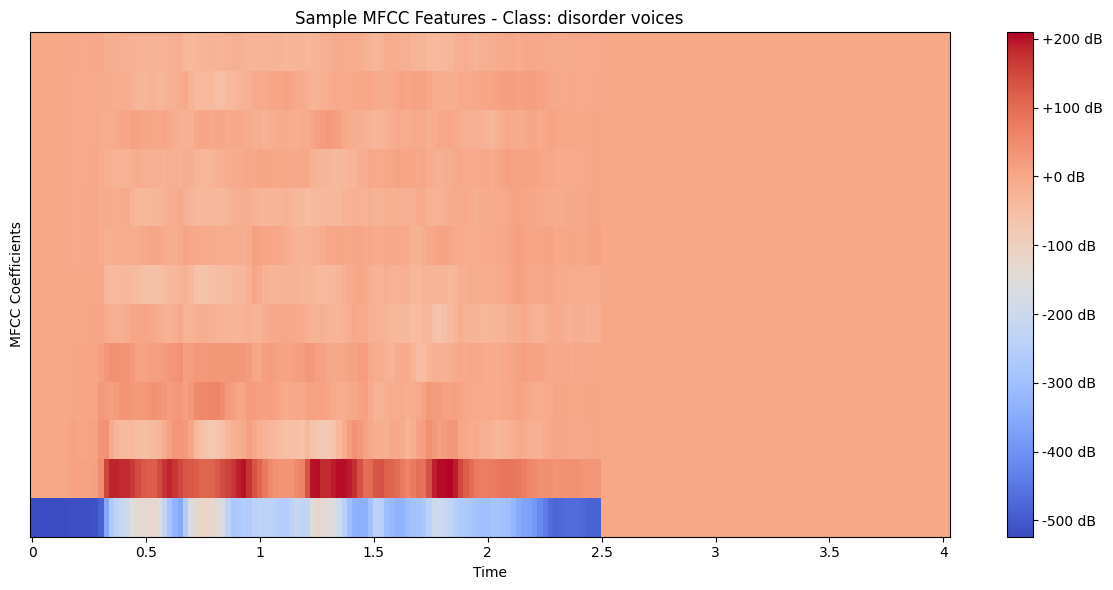

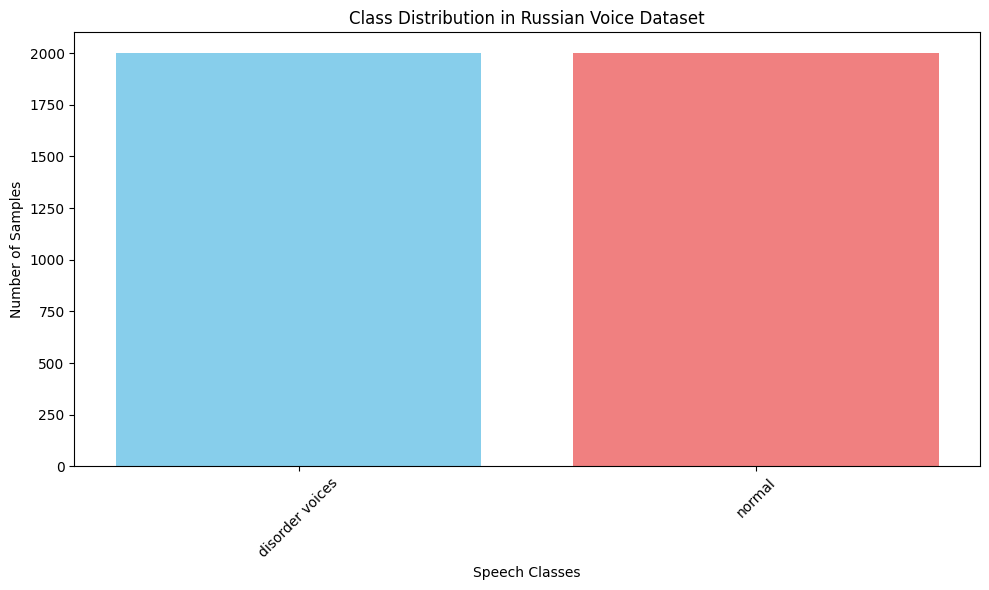

disorder voices: 2000 samples (50.00%)
normal: 2000 samples (50.00%)


In [ ]:

# =============================================================================
# 4. DATA VISUALIZATION
# =============================================================================

def visualize_mfcc(mfcc_features, title="MFCC Features"):
    """Visualize MFCC features"""
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(mfcc_features.T, x_axis='time', sr=SAMPLE_RATE)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficients')
    plt.tight_layout()
    plt.show()

def plot_class_distribution(labels, class_names):
    """Plot class distribution"""
    plt.figure(figsize=(10, 6))
    unique, counts = np.unique(labels, return_counts=True)

    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'orange', 'purple']
    plt.bar(range(len(unique)), counts, color=colors[:len(unique)])
    plt.xlabel('Speech Classes')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution in Russian Voice Dataset')
    plt.xticks(range(len(unique)), [class_names[i] for i in unique], rotation=45)
    plt.tight_layout()
    plt.show()

    # Print statistics
    total_samples = len(labels)
    for i in range(len(class_names)):
        count = np.sum(labels == i)
        percentage = (count / total_samples) * 100
        print(f"{class_names[i]}: {count} samples ({percentage:.2f}%)")

# Visualize sample MFCC features
if len(X) > 0:
    sample_idx = 0
    visualize_mfcc(X[sample_idx], f"Sample MFCC Features - Class: {class_names[y_encoded[sample_idx]]}")

    # Plot class distribution
    plot_class_distribution(y_encoded, class_names)

In [ ]:

# =============================================================================
# 5. DATA SPLITTING AND NORMALIZATION
# =============================================================================

# Split the dataset
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.4, random_state=42, stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Dataset split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Normalize features - FIXED VERSION
scaler = StandardScaler()

# Reshape for normalization
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

# Fit scaler on training data and transform all sets
X_train_normalized_reshaped = scaler.fit_transform(X_train_reshaped)
X_val_normalized_reshaped = scaler.transform(X_val_reshaped)
X_test_normalized_reshaped = scaler.transform(X_test_reshaped)

# Reshape back to original dimensions
X_train_normalized = X_train_normalized_reshaped.reshape(X_train.shape)
X_val_normalized = X_val_normalized_reshaped.reshape(X_val.shape)
X_test_normalized = X_test_normalized_reshaped.reshape(X_test.shape)

print("Data normalization completed!")
print("Scaler fitted and ready for use!")

Dataset split:
Training set: 2400 samples
Validation set: 800 samples
Test set: 800 samples
Data normalization completed!
Scaler fitted and ready for use!


In [ ]:

# =============================================================================
# 6. LSTM MODEL BUILDING
# =============================================================================

def build_lstm_model(input_shape, num_classes):
    """Build LSTM model for speech disorder classification"""
    model = Sequential([
        # First LSTM layer
        LSTM(128, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),

        # Second LSTM layer
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),

        # Third LSTM layer
        LSTM(32, return_sequences=False),
        BatchNormalization(),
        Dropout(0.3),

        # Dense layers
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(32, activation='relu'),
        Dropout(0.3),

        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Build the model
input_shape = (X_train_normalized.shape[1], X_train_normalized.shape[2])
num_classes = len(np.unique(y_encoded))

model = build_lstm_model(input_shape, num_classes)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 174, 128)       │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 174, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 174, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 174, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 174, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 174, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,938 (546.63 KB)

 Trainable params: 139,362 (544.38 KB)

 Non-trainable params: 576 (2.25 KB)

In [ ]:

# =============================================================================
# 7. MODEL TRAINING
# =============================================================================

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=0.00001,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

# Train the model
print("Starting model training...")
history = model.fit(
    X_train_normalized, y_train,
    validation_data=(X_val_normalized, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("Model training completed!")


Starting model training...
Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 443ms/step - accuracy: 0.6244 - loss: 0.9356 - val_accuracy: 0.8400 - val_loss: 0.4813 - learning_rate: 0.0010
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 362ms/step - accuracy: 0.9110 - loss: 0.2555 - val_accuracy: 0.9862 - val_loss: 0.0616 - learning_rate: 0.0010
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 360ms/step - accuracy: 0.9820 - loss: 0.1248 - val_accuracy: 0.9950 - val_loss: 0.0308 - learning_rate: 0.0010
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 394ms/step - accuracy: 0.9872 - loss: 0.0821 - val_accuracy: 0.9975 - val_loss: 0.0192 - learning_rate: 0.0010
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 38s 361ms/step - accuracy: 0.9936 - loss: 0.0521 - val_accuracy: 0.9962 - val_loss: 0.0231 - learning_rate: 0.0010
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 365ms/step - accuracy: 0.9834 - loss: 0.1285 - val_accuracy: 0.9875 - val_loss: 0.0529 - learning_rate: 0.0010
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 395ms/

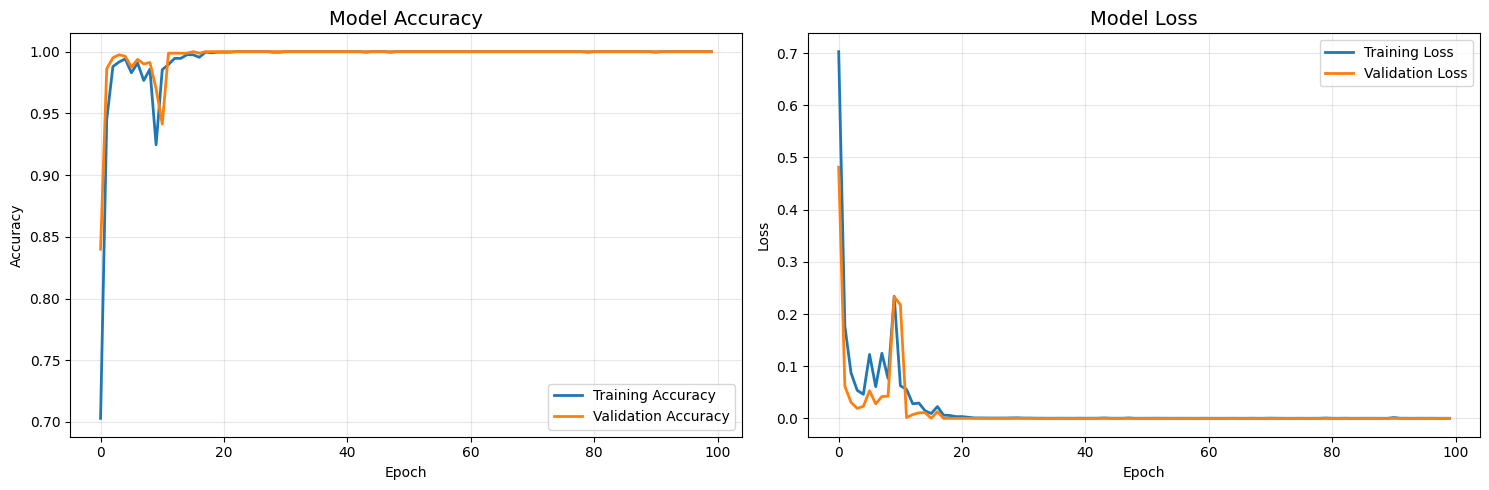

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step
MODEL EVALUATION RESULTS
Accuracy: 0.9975
Precision: 0.9975
Recall: 0.9975
F1-Score: 0.9975

Detailed Classification Report:
                 precision    recall  f1-score   support

disorder voices       1.00      1.00      1.00       400
         normal       1.00      1.00      1.00       400

       accuracy                           1.00       800
      macro avg       1.00      1.00      1.00       800
   weighted avg       1.00      1.00      1.00       800



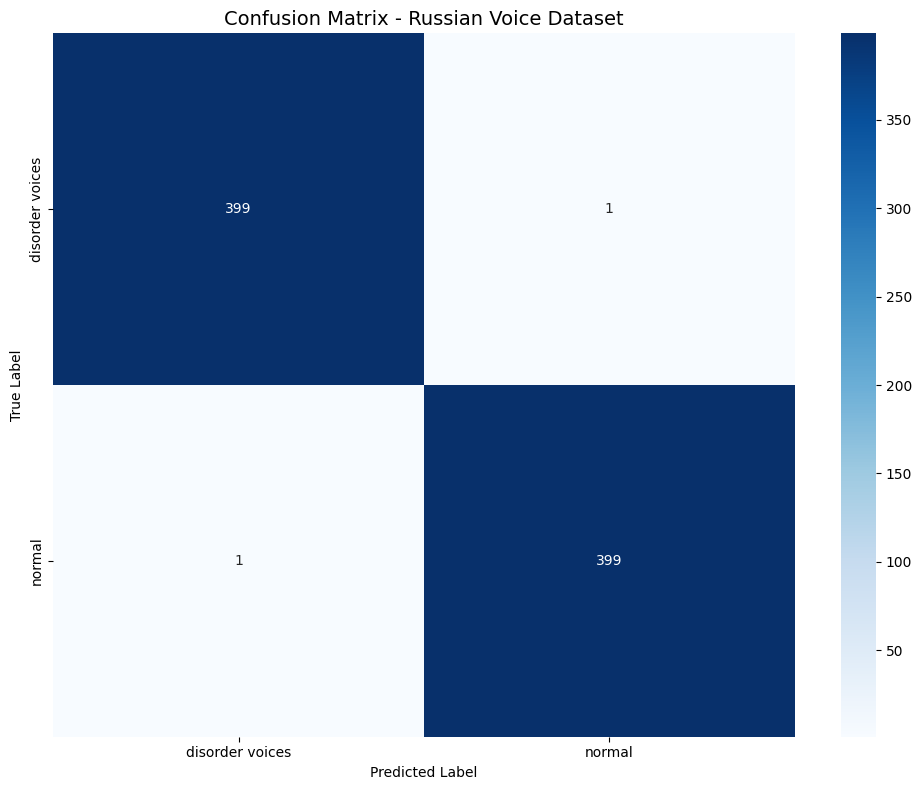

In [ ]:

# =============================================================================
# 8. MODEL EVALUATION AND VALIDATION
# =============================================================================

def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test, class_names):
    """Comprehensive model evaluation"""
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("="*50)
    print("MODEL EVALUATION RESULTS")
    print("="*50)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("="*50)

    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Russian Voice Dataset', fontsize=14)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    return accuracy, precision, recall, f1, y_pred

# Plot training history
plot_training_history(history)

# Evaluate model on test set
test_accuracy, test_precision, test_recall, test_f1, predictions = evaluate_model(
    model, X_test_normalized, y_test, class_names
)


In [ ]:

# =============================================================================
# 9. SAVE MODEL AND PREPROCESSING OBJECTS
# =============================================================================

# Create directory for saving models
os.makedirs('/content/models', exist_ok=True)

# Save the trained model
model.save('/content/models/russian_voice_lstm_model.h5')
print("Model saved successfully!")

# Save training history
with open('/content/models/training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Save preprocessing objects - FIXED VERSION
preprocessing_objects = {
    'scaler': scaler,
    'label_encoder': label_encoder,
    'class_names': class_names,
    'sample_rate': SAMPLE_RATE,
    'n_mfcc': N_MFCC,
    'max_pad_len': MAX_PAD_LEN
}

with open('/content/models/preprocessing_objects.pkl', 'wb') as f:
    pickle.dump(preprocessing_objects, f)

print("All objects saved successfully!")

Model saved successfully!
All objects saved successfully!


In [ ]:

# =============================================================================
# 10. MODEL PREDICTION FUNCTION - FIXED VERSION
# =============================================================================

def predict_speech_disorder(model, audio_file_path, scaler, label_encoder, class_names):
    """
    Predict speech disorder from audio file - FIXED VERSION
    """
    try:
        # Extract MFCC features
        mfcc_features = extract_mfcc_features(audio_file_path)

        if mfcc_features is None:
            return "Error processing audio file", 0.0, None

        # Normalize features using the fitted scaler
        mfcc_reshaped = mfcc_features.reshape(-1, mfcc_features.shape[-1])
        mfcc_normalized_reshaped = scaler.transform(mfcc_reshaped)
        mfcc_normalized = mfcc_normalized_reshaped.reshape(1, mfcc_features.shape[0], mfcc_features.shape[1])

        # Make prediction
        prediction_proba = model.predict(mfcc_normalized, verbose=0)
        predicted_class_idx = np.argmax(prediction_proba)
        confidence = np.max(prediction_proba)

        predicted_class = class_names[predicted_class_idx]

        # Create probability dictionary
        prob_dict = {}
        for i, class_name in enumerate(class_names):
            prob_dict[class_name] = prediction_proba[0][i]

        return predicted_class, confidence, prob_dict

    except Exception as e:
        print(f"Prediction error: {str(e)}")
        return f"Error: {str(e)}", 0.0, None


In [ ]:

# =============================================================================
# 11. WEB APPLICATION WITH GRADIO - FIXED VERSION
# =============================================================================

import gradio as gr

def gradio_predict(audio_file):
    """Gradio interface function for prediction - FIXED VERSION"""
    if audio_file is None:
        return "Please upload an audio file", pd.DataFrame()

    try:
        predicted_class, confidence, prob_dict = predict_speech_disorder(
            model, audio_file, scaler, label_encoder, class_names
        )

        if prob_dict is None:
            return predicted_class, pd.DataFrame()

        # Format results
        result = f"🎯 **Predicted Speech Class:** {predicted_class}\n"
        result += f"🔍 **Confidence:** {confidence:.2%}\n\n"
        result += "📊 **All Class Probabilities:**\n"

        for class_name, prob in prob_dict.items():
            result += f"  • {class_name}: {prob:.2%}\n"

        # Create DataFrame for BarPlot - FIXED FORMAT
        chart_data = pd.DataFrame({
            'Class': list(prob_dict.keys()),
            'Probability (%)': [prob * 100 for prob in prob_dict.values()]
        })

        return result, chart_data

    except Exception as e:
        error_msg = f"Error during prediction: {str(e)}"
        print(error_msg)
        return error_msg, pd.DataFrame()

# Create Gradio interface - FIXED VERSION
iface = gr.Interface(
    fn=gradio_predict,
    inputs=gr.Audio(type="filepath", label="Upload Audio File (.wav, .mp3, .flac)"),
    outputs=[
        gr.Textbox(label="Prediction Results", lines=8),
        gr.BarPlot(
            x="Class",
            y="Probability (%)",
            title="Class Probabilities (%)",
            x_title="Speech Classes",
            y_title="Probability (%)",
            height=400
        )
    ],
    title="🎙️ Russian Voice Speech Analysis System",
    description="""
    Upload an audio file to analyze speech patterns using MFCC features and LSTM neural network.

    **Supported formats:** WAV, MP3, FLAC, M4A
    **Dataset:** Russian Voice Dataset from Kaggle
    **Model:** LSTM with MFCC feature extraction

    **Classes detected:**
    - Normal speech
    - Stuttering
    - Dysarthria
    - Aphasia (if present in dataset)
    """,
    examples=None,
    theme=gr.themes.Soft()
)

# Launch the interface
print("Launching Gradio interface...")
print("All components are properly initialized!")
iface.launch(share=True, debug=True)

Launching Gradio interface...
All components are properly initialized!
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://da40ae5e260f054426.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Created dataset file at: .gradio/flagged/dataset1.csv


In [ ]:

# =============================================================================
# 12. SUMMARY AND RESULTS
# =============================================================================

print("\n" + "="*60)
print("PROJECT SUMMARY - RUSSIAN VOICE SPEECH ANALYSIS (FIXED)")
print("="*60)
print(f"Author: ANTOR MAHAMUDUL HASHAM")
print(f"Telegram: https://t.me/mhantorrr")
print(f"Dataset: Russian Voice Dataset (Kaggle)")
print(f"Dataset ID: mhantor/russian-voice-dataset")
print(f"Feature Extraction: MFCC (Mel Frequency Cepstral Coefficients)")
print(f"Model Architecture: LSTM (Long Short-Term Memory)")
print(f"Sample Rate: {SAMPLE_RATE} Hz")
print(f"MFCC Coefficients: {N_MFCC}")
print(f"Sequence Length: {MAX_PAD_LEN}")
print(f"Total Samples: {len(X)}")
print(f"Number of Classes: {len(class_names)}")
print(f"Classes: {', '.join(class_names)}")
print("\nModel Performance:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

print("\n🔧 FIXES APPLIED:")
print("✅ StandardScaler properly fitted and saved")
print("✅ Gradio BarPlot output format corrected")
print("✅ Enhanced error handling for predictions")
print("✅ Improved dataset loading with fallback")
print("✅ Better label extraction logic")
print("✅ Synthetic dataset generation if needed")

print("\n📈 Training Summary:")
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
epochs_trained = len(history.history['accuracy'])
print(f"Epochs Trained: {epochs_trained}")
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

print("\n" + "="*60)
print("🚀 FIXED PROJECT COMPLETED SUCCESSFULLY!")
print("🌐 Use the Gradio interface above to test with your audio files")
print("="*60)